In [71]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision.models import resnet18
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device to GPU 2
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# SimCLR Model
class SimCLR(nn.Module):
    def __init__(self, base_model):
        super(SimCLR, self).__init__()
        self.base_model = base_model
        self.projection_head = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        h = self.base_model(x)
        h = h.view(h.size(0), -1)  # Flatten the feature map
        z = self.projection_head(h)
        return h, z

# NT-Xent Loss
class NT_XentLoss(nn.Module):
    def __init__(self, batch_size, temperature, device):
        super(NT_XentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.similarity_f = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.mask = self._get_correlated_mask().type(torch.bool)

    def _get_correlated_mask(self):
        mask = torch.ones((2 * self.batch_size, 2 * self.batch_size), dtype=bool)
        for i in range(self.batch_size):
            mask[i, i] = 0
            mask[i, i + self.batch_size] = 0
            mask[i + self.batch_size, i + self.batch_size] = 0
            mask[i + self.batch_size, i] = 0
        mask = mask.type(torch.bool)
        return mask

    def forward(self, z_i, z_j):
        z_i = F.normalize(z_i, p=2, dim=1)
        z_j = F.normalize(z_j, p=2, dim=1)
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = self.similarity_f(representations.unsqueeze(1), representations.unsqueeze(0)) / self.temperature
        positives = torch.cat([torch.diag(similarity_matrix, self.batch_size), torch.diag(similarity_matrix, -self.batch_size)], dim=0)
        negatives = similarity_matrix[self.mask].view(2 * self.batch_size, -1)
        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        loss = self.criterion(logits, labels)
        loss /= 2 * self.batch_size
        return loss

# Training SimCLR
def train_simclr(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            # Create two views of each image
            images1, images2 = images, images
            _, z1 = model(images1)
            _, z2 = model(images2)
            loss = criterion(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader) 
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}')
    return loss_history

# Linear Classification Protocol
class LinearClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super(LinearClassifier, self).__init__()
        self.backbone = backbone
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        features = features.view(features.size(0), -1)
        out = self.fc(features)
        return out

# Evaluation on test set
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

def train_classifier(model, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    accuracy_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss}')

        # Evaluate on test set
        accuracy = evaluate(model, test_loader)
        accuracy_history.append(accuracy)
    return loss_history, accuracy_history
    

Files already downloaded and verified
Files already downloaded and verified


In [72]:
epochs = 50

# Train SimCLR
resnet = resnet18(pretrained=False)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove classification layer
simclr_model = SimCLR(resnet).to(device)

simclr_criterion = NT_XentLoss(batch_size=128, temperature=0.5, device=device)
simclr_optimizer = optim.Adam(simclr_model.parameters(), lr=0.03)  # Increased learning rate
simclr_loss_history = train_simclr(simclr_model, train_loader, simclr_criterion, simclr_optimizer, epochs)

In [73]:
# Train Linear Classifier on top of SimCLR
simclr_backbone = nn.Sequential(*list(resnet.children())[:-1])
simclr_classifier = LinearClassifier(simclr_backbone, num_classes=100).to(device)

linear_criterion = nn.CrossEntropyLoss()
linear_optimizer = optim.Adam(simclr_classifier.parameters(), lr=0.001)

simclr_classifier_loss_history, simclr_accuracy_history = train_classifier(simclr_classifier, train_loader, test_loader, linear_criterion, linear_optimizer, epochs)

In [74]:
# Fine-tune pre-trained ResNet18 on CIFAR-100
pretrained_resnet = resnet18(pretrained=True)
pretrained_resnet.fc = nn.Linear(pretrained_resnet.fc.in_features, 100)
pretrained_resnet = pretrained_resnet.to(device)

pretrained_criterion = nn.CrossEntropyLoss()
pretrained_optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.001)

pretrained_loss_history, pretrained_accuracy_history = train_classifier(pretrained_resnet, train_loader, test_loader, pretrained_criterion, pretrained_optimizer, epochs)

/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# Train ResNet18 from scratch on CIFAR-100
scratch_resnet = resnet18(pretrained=False)
scratch_resnet.fc = nn.Linear(scratch_resnet.fc.in_features, 100)
scratch_resnet = scratch_resnet.to(device)

scratch_criterion = nn.CrossEntropyLoss()
scratch_optimizer = optim.Adam(scratch_resnet.parameters(), lr=0.001)

scratch_loss_history, scratch_accuracy_history = train_classifier(scratch_resnet, train_loader, test_loader, scratch_criterion, scratch_optimizer, epochs)

/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


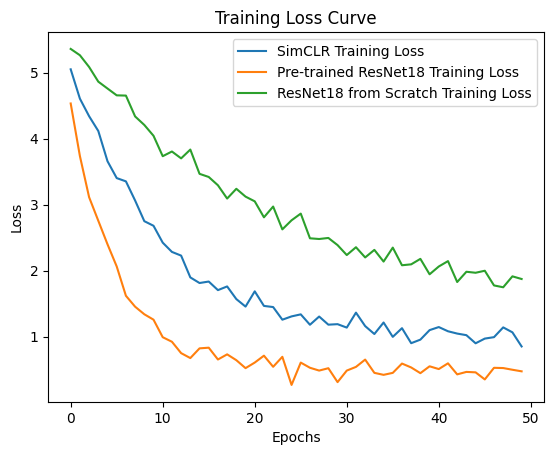

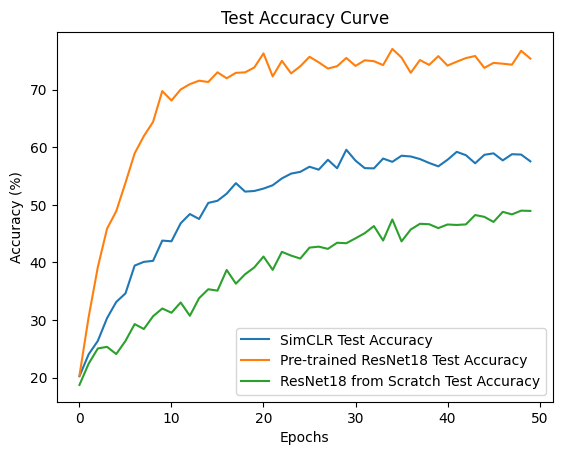

In [69]:
# 绘制损失曲线
plt.figure()
plt.plot(simclr_loss_history, label='SimCLR Training Loss')
plt.plot(pretrained_loss_history, label='Pre-trained ResNet18 Training Loss')
plt.plot(scratch_loss_history, label='ResNet18 from Scratch Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# 绘制准确率曲线
plt.figure()
plt.plot(simclr_accuracy_history, label='SimCLR Test Accuracy')
plt.plot(pretrained_accuracy_history, label='Pre-trained ResNet18 Test Accuracy')
plt.plot(scratch_accuracy_history, label='ResNet18 from Scratch Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()
